In [114]:
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import copy
import os
import torch
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset

In [180]:
import pandas as pd
train_label = pd.read_csv('./TrainLabels.csv')
valid_label = pd.read_csv('./DAiSEE/Labels/ValidationLabels.csv')
valid_label.head(10)

,ClipID,Boredom,Engagement,Confusion,Frustration
0,4000221001.avi,0,2,0,0
1,4000221002.avi,1,3,0,0
2,4000221006.avi,1,2,0,0
3,4000221008.avi,0,3,0,0
4,4000221009.avi,2,2,0,0
5,4000221010.avi,2,2,1,1
6,4000221011.avi,2,2,1,0
7,4000221013.avi,3,2,0,0
8,4000221014.avi,2,2,0,1
9,4000221015.avi,3,2,3,0


In [116]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
from tqdm.autonotebook import tqdm
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import sys
im_size = 224
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor()])

In [117]:
class video_dataset(Dataset):
    def __init__(self,frame_dir,train_csv,sequencelength = 60,skip_length = 5,transform = None):
        self.folder = os.listdir(frame_dir)
        self.id = train_csv['ClipID']
        self.engagement = train_csv['Engagement']
        self.frame_dir = frame_dir
        self.transform = transform
        self.not_exist = list()
    def __len__(self):
        return len(self.id)
    def __getitem__(self,idx):
        id_1 = self.id[idx][:6]
        path1 = os.path.join(self.frame_dir,id_1)
        id_2 = self.id[idx][:-4]
        path2 = os.path.join(path1,id_2)
        seq_image = list()
        i = 0
        while i<300:
            path3 = os.path.join(path2,str(i)+'.jpg')
            image = cv2.imread(path3)
            if(self.transform):
                image = self.transform(image)
            seq_image.append(image)
            i = i+5
        seq_image = torch.stack(seq_image)
        label = self.engagement[idx]
        seq_image = seq_image.reshape(3,60,im_size,im_size)
        return seq_image,label

In [167]:
mean = [0.4889, 0.4887, 0.4891, 0.4888, 0.4891, 0.4887, 0.4891, 0.4887, 0.4891,
        0.4888, 0.4891, 0.4887, 0.4889, 0.4887, 0.4891, 0.4887, 0.4891, 0.4887,
        0.4891, 0.4887, 0.4891, 0.4888, 0.4891, 0.4887, 0.4888, 0.4887, 0.4891,
        0.4887, 0.4891, 0.4887, 0.4891, 0.4888, 0.4891, 0.4888, 0.4891, 0.4887,
        0.4889, 0.4887, 0.4892, 0.4888, 0.4891, 0.4887, 0.4891, 0.4888, 0.4891,
        0.4888, 0.4891, 0.4887, 0.4889, 0.4887, 0.4891, 0.4887, 0.4891, 0.4886,
        0.4890, 0.4887, 0.4891, 0.4888, 0.4891, 0.4888]

In [169]:
std = [0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074,
        0.2074, 0.2074, 0.2074, 0.2074, 0.2073, 0.2074, 0.2074, 0.2073, 0.2074,
        0.2073, 0.2073, 0.2073, 0.2074, 0.2074, 0.2074, 0.2073, 0.2073, 0.2074,
        0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074,
        0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074,
        0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074,
        0.2073, 0.2074, 0.2074, 0.2074, 0.2074, 0.2074]

In [181]:
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.ToTensor()])
test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        #transforms.RandomRotation(degrees=10),
                                        transforms.ToTensor()])
train_data = video_dataset('./frames/train',train_label,transform = train_transforms)
val_data = video_dataset('./frames/val',valid_label,transform = test_transforms)
train_loader = DataLoader(train_data,batch_size = 4,num_workers = 4 ,shuffle = True)
valid_loader = DataLoader(val_data,batch_size = 4,num_workers = 4 ,shuffle = True)
dataloaders = {'train':train_loader,'val':valid_loader}

In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

__all__ = ['DenseNet', 'densenet121', 'densenet161'] # with DropOut

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm3d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv3d(num_input_features, bn_size *
                        growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv3d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm3d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv3d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool3d(kernel_size=2, stride=2))


class DenseNet3D(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000):

        super(DenseNet3D, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv3d(3, num_init_features, kernel_size=(3, 7, 7), stride=2, padding=(1, 3, 3), bias=False)),
            ('norm0', nn.BatchNorm3d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool3d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm3d(num_features))
        # Linear layer
        self.linear = nn.Linear(2048, 512)
        self.elu = nn.ELU()
        self.out = nn.Linear(512, 4)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        avg_pool = nn.functional.adaptive_avg_pool3d(out, output_size = 1)
        max_pool = nn.functional.adaptive_max_pool3d(out, output_size = 1)
        out = torch.cat((avg_pool,max_pool),1)
        batch = out.shape[0]
        out = out.view(batch, -1)
        conc = self.elu(self.linear(self.dropout1(out)))
        res = self.out(self.dropout2(conc))
        #out = F.avg_pool3d(out, kernel_size=(1,7,7)).view(features.size(0), -1)
        return res


def densenet121_3D():
    model = DenseNet3D(num_init_features=64, growth_rate=32, block_config=(6, 12, 24, 16))
    return model


def densenet121_3D_DropOut():
    model = DenseNet3D(num_init_features=64, growth_rate=32, block_config=(6, 12, 24, 16), drop_rate=0.2)
    return model


def densenet169_3D():
    model = DenseNet3D(num_init_features=64, growth_rate=32, block_config=(6, 12, 32, 32))
    return model


# the below model has the lowest Top-1 error in ImageNet Data Set:
def densenet161_3D():
    model = DenseNet3D(num_init_features=96, growth_rate=48, block_config=(6, 12, 36, 24))
    return model


# the below model has the lowest Top-1 error in ImageNet Data Set:
def densenet161_3D_DropOut():
    model = DenseNet3D(num_init_features=96, growth_rate=48, block_config=(6, 12, 36, 24), drop_rate=0.2)
    return model


def densenet201_3D():
    model = DenseNet3D(num_init_features=64, growth_rate=32, block_config=(6, 12, 48, 32))
    return model


def densenet121(**kwargs):
    """Constructs a DenseNet-121_DropOut model.
    """
    model = DenseNet3D(num_init_features=64, growth_rate=32, block_config=(6, 12, 24, 16), drop_rate=0.2, **kwargs)
    return model


def densenet161(**kwargs):
    """Constructs a DenseNet-161_DropOut model.
    """
    model = DenseNet3D(num_init_features=96, growth_rate=48, block_config=(6, 12, 36, 24), drop_rate=0.2, **kwargs)
    return model

In [189]:
model = densenet121_3D_DropOut().to('cuda')

In [190]:
model = model.to('cuda')
model = nn.DataParallel(model)

In [126]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

In [134]:
def lr_finder(model,train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(model.parameters(), lr=0.0000001)
    lr_finder = LRFinder(model, optimizer_ft, criterion, device=device)
    lr_finder.range_test(train_loader, end_lr=1, num_iter=1000)
    lr_finder.reset()
    lr_finder.plot()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


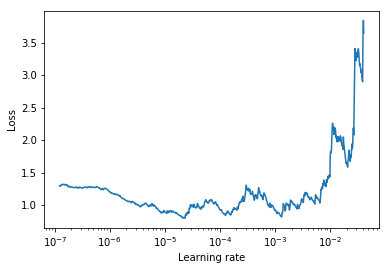

In [135]:
#lr_finder(model,train_loader)

In [191]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()
device = 'cuda'
cls_criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
onecyc = OneCycle(len(train_loader)*num_epochs,1e-3)

In [ ]:
from torch.autograd import Variable
for epoch in range(num_epochs):
    print('')
    print(f"--- Epoch {epoch} ---")
    phase1 = dataloaders.keys()
    acc_all = list()
    loss_all = list()
    for phase in phase1:
        print('')
        print(f"--- Phase {phase} ---")
        epoch_metrics = {"loss": [], "acc": []}
        if phase == ' train':
            model.train()
        else:
            model.eval()
        for batch_i, (X, y) in enumerate(dataloaders[phase]):
            image_sequences = Variable(X.to(device), requires_grad=True)
            labels = Variable(y.to(device), requires_grad=False)
            optimizer.zero_grad()
            #model.lstm.reset_hidden_state()
            predictions = model(image_sequences)
            loss = cls_criterion(predictions, labels)
            acc = 100 * (predictions.detach().argmax(1) == labels).cpu().numpy().mean()
            loss.backward()
            optimizer.step()
            epoch_metrics["loss"].append(loss.item())
            epoch_metrics["acc"].append(acc)
            if(phase=='train'):
                lr,_ = onecyc.calc()
                update_lr(optimizer, lr)
            batches_done = epoch * len(dataloaders[phase]) + batch_i
            batches_left = num_epochs * len(dataloaders[phase]) - batches_done

            sys.stdout.write(
                    "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
                    % (
                        epoch,
                        num_epochs,
                        batch_i,
                        len(dataloaders[phase]),
                        loss.item(),
                        np.mean(epoch_metrics["loss"]),
                        acc,
                        np.mean(epoch_metrics["acc"]),
                    )
                )

                # Empty cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        if(phase=='train'):
            writer.add_scalar('data/acc',np.mean(epoch_metrics["acc"]) , epoch)
            writer.add_scalar('data/loss',np.mean(epoch_metrics["loss"]) , epoch)
            acc_all.append(np.mean(epoch_metrics["acc"]))
            loss_all.append(np.mean(epoch_metrics["loss"]))
        if(phase=='val'):
            writer.add_scalar('data/valacc',np.mean(epoch_metrics["acc"]) , epoch)
            writer.add_scalar('data/valloss',np.mean(epoch_metrics["loss"]) , epoch)
        print('{} , acc:'.format(phase,np.mean(epoch_metrics["acc"])))


--- Epoch 0 ---

--- Phase train ---
[Epoch 0/10] [Batch 363/1340] [Loss: 0.779477 (0.924240), Acc: 50.00% (47.87%)]]

In [80]:
torch.save(model.state_dict(),'./t3d_10.h5')

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


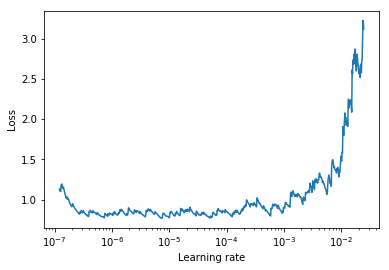

In [81]:
lr_finder(model,train_loader)

In [97]:
model.load_state_dict(torch.load('./t3d_10.h5'))
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum = 0.9)
num_epochs = 5
onecyc = OneCycle(len(train_loader)*num_epochs,0.001)

In [98]:
from torch.autograd import Variable
for epoch in range(num_epochs):
    epoch_metrics1 = {"loss": [], "acc": []}
    print('')
    print(f"--- Epoch {epoch} ---")
    for batch_i, (X, y) in enumerate(train_loader):
        image_sequences = Variable(X.to(device), requires_grad=True)
        labels = Variable(y.to(device), requires_grad=False)
        optimizer.zero_grad()
        #model.lstm.reset_hidden_state()
        predictions = model(image_sequences)
        loss = cls_criterion(predictions, labels)
        acc = 100 * (predictions.detach().argmax(1) == labels).cpu().numpy().mean()
        loss.backward()
        optimizer.step()
        epoch_metrics["loss"].append(loss.item())
        epoch_metrics["acc"].append(acc)
        
        lr,mom = onecyc.calc()
        update_lr(optimizer, lr)
        update_mom(optimizer, mom)
        batches_done = epoch * len(train_loader) + batch_i
        batches_left = num_epochs * len(train_loader) - batches_done
        
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
                % (
                    epoch,
                    num_epochs,
                    batch_i,
                    len(train_loader),
                    loss.item(),
                    np.mean(epoch_metrics["loss"]),
                    acc,
                    np.mean(epoch_metrics["acc"]),
                )
            )

            # Empty cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    writer.add_scalar('data/acc',np.mean(epoch_metrics["acc"]) , epoch)
    writer.add_scalar('data/loss',np.mean(epoch_metrics["loss"]) , epoch)

--- Epoch 0 ---
[Epoch 0/5] [Batch 256/1340] [Loss: 0.764911 (0.859098), Acc: 50.00% (53.50%)]]

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(),'./t3d_10.h5')
lr_finder(model,train_loader)

In [ ]:
model.load_state_dict(torch.load('./t3d_10.h5'))
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum = 0.9)
num_epochs = 5
onecyc = OneCycle(len(train_loader)*num_epochs,0.001)